<a href="https://colab.research.google.com/github/bayashi-cl/statistical-learning/blob/main/note/04_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from statsmodels.formula.api import logit
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("ISLR2")
library(ISLR2)

In [6]:
%%R -o default
default <- ISLR2::Default
summary(default)

 default    student       balance           income     
 No :9667   No :7056   Min.   :   0.0   Min.   :  772  
 Yes: 333   Yes:2944   1st Qu.: 481.7   1st Qu.:21340  
                       Median : 823.6   Median :34553  
                       Mean   : 835.4   Mean   :33517  
                       3rd Qu.:1166.3   3rd Qu.:43808  
                       Max.   :2654.3   Max.   :73554  


# 4 分類

## 4.1 概要

この章では次のような分類問題を考える。

1. 救急処置室に来た患者がどんな状態か
1. オンライン銀行で行われている取引は適切か
1. どのようなDNAが病気の原因となるか


## 4.2 線形回帰との比較

救急処置室に来た患者が`心臓発作`、`薬物中毒`、`てんかん`のどれに該当するかを分類したい。しかし、仮に目的変数を

$$
Y=
\begin{cases}
  1 & 心臓発作\\
  2 & 薬物中毒\\
  3 & てんかん
\end{cases}
$$

のように設定してしまうと、要素の間に「順序」を生じさせてしまう。

つぎに2値分類

$$
Y=
\begin{cases}
  0 & 心臓発作\\
  1 & 薬物中毒
\end{cases}
$$

を考える。この場合は線形回帰を用いた予測値 $\hat{Y}$ が0.5を超えれば薬物中毒、そうでなければ心臓発作と判定することができる。ただ、線形回帰の場合は予測値が実数全体をとり得るので、確率として解釈するのが難しい。

まとめると分類問題に線形回帰を適用すると

* 3クラス以上の質的変数を扱えない
* 2クラスの場合も予測値がほとんど意味を持たない。

という問題が生じる。

## 4.3 ロジスティック回帰

ここでは`balance`データセットを用いて債務の量からが債務不履行に陥る確率を予測する。

$$\textrm{Pr}(\textrm{default}=\textrm{Yes}|\textrm{balance})$$
を単に $p(\textrm{balance})$ とする。

### 4.3.1 ロジスティックモデル

値域が $[0, 1]$ のうち、 **ロジスティック関数**

$$p(X) = \frac{e^{\beta_0+\beta_1X}}{1+e^{\beta_0+\beta_1X}}$$

を使う。この式を変形する。

$$\frac{p(X)}{1-p(X)} = e^{\beta_0+\beta_1X}$$

この式の左辺は**オッズ**と呼ばれていて、 $[0,\infty]$ をとる。

さらに、両辺の対数を取ると

$$\log{\left(\frac{p(X)}{1-p(X)}\right)} = \beta_0+\beta_1X$$

となり、左辺は**ロジット**と呼ばれている

In [7]:
default = pd.get_dummies(default, columns=["default", "student"], drop_first=True)
default.describe()

,balance,income,default_Yes,student_Yes
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,835.374886,33516.981876,0.033300,0.294400
std,483.714985,13336.639563,0.179428,0.455795
min,0.000000,771.967729,0.000000,0.000000
25%,481.731105,21340.462903,0.000000,0.000000
50%,823.636973,34552.644802,0.000000,0.000000
75%,1166.308386,43807.729272,0.000000,1.000000
max,2654.322576,73554.233495,1.000000,1.000000


In [8]:
X = default[["balance"]]
y = default["default_Yes"]

# 学習(scikit-learn)
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


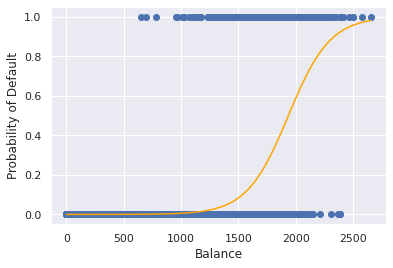

In [9]:
reg_X = np.linspace(default["balance"].min(), default["balance"].max(), 100).reshape((-1, 1))
plt.scatter(X, y)
plt.plot(reg_X, lr.predict_proba(reg_X)[:,1], color="orange")
plt.xlabel("Balance")
plt.ylabel("Probability of Default")
plt.show()

### 4.3.2 回帰係数の推定

パラメーターの推定には最尤法を用いる。すなわち、尤度関数

$$l(\beta_0, \beta_1) = \prod_{i:y_i=1}p(x_i)\prod_{i':y_{i'}=0}(1-p(x_{i'}))$$

を最大化するパラメータが選ばれる。



In [10]:
model_balance = logit(formula="default_Yes ~ balance", data=default).fit()
print(model_balance.summary())

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:            default_Yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Mon, 27 Dec 2021   Pseudo R-squ.:                  0.4534
Time:                        04:58:06   Log-Likelihood:                -798.23
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                6.233e-290
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.6513      0.361    -29.491      0.000     -11.359      -9.943
balance        0.0055      0

In [11]:
model_student = logit(formula="default_Yes ~ student_Yes", data=default).fit()
print(model_student.summary())

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            default_Yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Mon, 27 Dec 2021   Pseudo R-squ.:                0.004097
Time:                        04:58:07   Log-Likelihood:                -1454.3
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                 0.0005416
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.5041      0.071    -49.554      0.000      -3.643      -3.366
student_Yes     0.4049    

ここでの**z値**が回帰でのt値に相当する

### 4.3.3 予測

### 4.3.4 多変量ロジスティック回帰

重回帰の場合と同様に多変量に拡張する

$$p(X) = \frac{e^{\beta_0+\beta_1X_1+\cdots+\beta_pX_p}}{1+e^{\beta_0+\beta_1X_1+\cdots+\beta_pX_p}}$$

$$\log{\left(\frac{p(X)}{1-p(X)}\right)} = \beta_0+\beta_1X_1+\cdots+\beta_pX_p$$

In [12]:
model_multi = logit(formula="default_Yes ~ balance + income + student_Yes", data=default).fit()
print(model_multi.summary())

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:            default_Yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Mon, 27 Dec 2021   Pseudo R-squ.:                  0.4619
Time:                        04:58:07   Log-Likelihood:                -785.77
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                3.257e-292
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -10.8690      0.492    -22.079      0.000     -11.834      -9.904
balance         0.0057   

`student`に注目すると、p値がどちらも小さいのにも関わらず、回帰係数が1変数の場合が正なのに対して多変量の場合は負になっている。

1変量の係数が正であるということは単に学生の方が債務不履行に陥った人の割合が高いことを表している。

多変量の係数が負であるということは、債務と収入の値が一定なら、学生の方が債務不履行に陥る確率が低いことを表している。

In [13]:
dysy = len(default[(default["default_Yes"]==1) & (default["student_Yes"]==1)]) 
sy = len(default[default["student_Yes"]==1])
p_sy = dysy / sy
print(f"p(student = Yes) = {p_sy:.5f}")

dysn = len(default[(default["default_Yes"]==1) & (default["student_Yes"]==0)]) 
sn = len(default[default["student_Yes"]==0])
p_sn = dysn / sn
print(f"p(student = No ) = {p_sn:.5f}")

p(student = Yes) = 0.04314
p(student = No ) = 0.02920


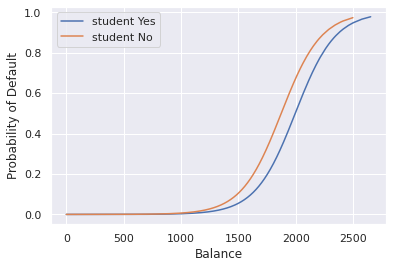

In [14]:
# 負債と学生の2変数
X = default[["balance", "student_Yes"]]
y = default["default_Yes"]
lr_bs = LogisticRegression()
lr_bs.fit(X, y)

X_sy = default[["balance", "student_Yes"]][default["student_Yes"] == 1].sort_values(by="balance")
plt.plot(X_sy["balance"], lr_bs.predict_proba(X_sy)[:,1], label="student Yes")
X_sy = default[["balance", "student_Yes"]][default["student_Yes"] == 0].sort_values(by="balance")
plt.plot(X_sy["balance"], lr_bs.predict_proba(X_sy)[:,1], label="student No")
plt.xlabel("Balance")
plt.ylabel("Probability of Default")
plt.legend()
plt.show()

これは`student`と`balance`の間に相関関係があるためで、学生のほうが多くの負債を抱える傾向があり、それによって債務不履行に陥る確率が高くなっている。

このような現象は**交絡**と呼ばれ、他の説明変数の関連が考えられる場合に単回帰をすると発生する可能性がある。

### 4.3.5 多クラス分類

多クラスの分類では、まず基準となるクラスを定め、そのクラスに対するオッズを計算する。

回帰係数はどのクラスを基準とするかによって異なってくるが、予測値はどのクラスを基準にとっても同一のものとなる。

すべてのクラスを対称に扱う手法としては**ソフトマックス関数**を用いるものがある。



In [21]:
iris = load_iris()
print(iris.DESCR)

In [ ]:
# 学習
X = iris.data[:, [0, 2]]
y = iris.target

model_iris = LogisticRegression(max_iter=1000)
model_iris.fit(X, y)

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


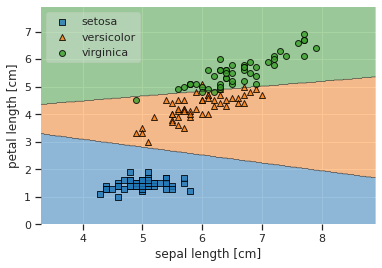

In [29]:
# 分類境界をプロット
ax = plot_decision_regions(X, y, clf=model_iris, legend=2)

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          iris.target_names, 
           framealpha=0.3, scatterpoints=1)

plt.show()